
### Importing Libraries

In [1]:
import re
import json
import warnings
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm
import many_stop_words
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder


In [2]:
warnings.filterwarnings("ignore")
check = Speller(lang='en')
le = LabelEncoder()
stop_words = list(set(stopwords.words("english")))
lemmatizer = WordNetLemmatizer()
#stop_words = many_stop_words.get_stop_words("en")
stemmer = PorterStemmer()
with open("normalize_mapping.json") as normalize_json_file_obj:
    normalize_json = json.load(normalize_json_file_obj)


### Loading Data

In [3]:
train, test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.duplicated().sum()

0

In [6]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
set(train.keyword.unique()) - set(test.keyword.unique())

set()

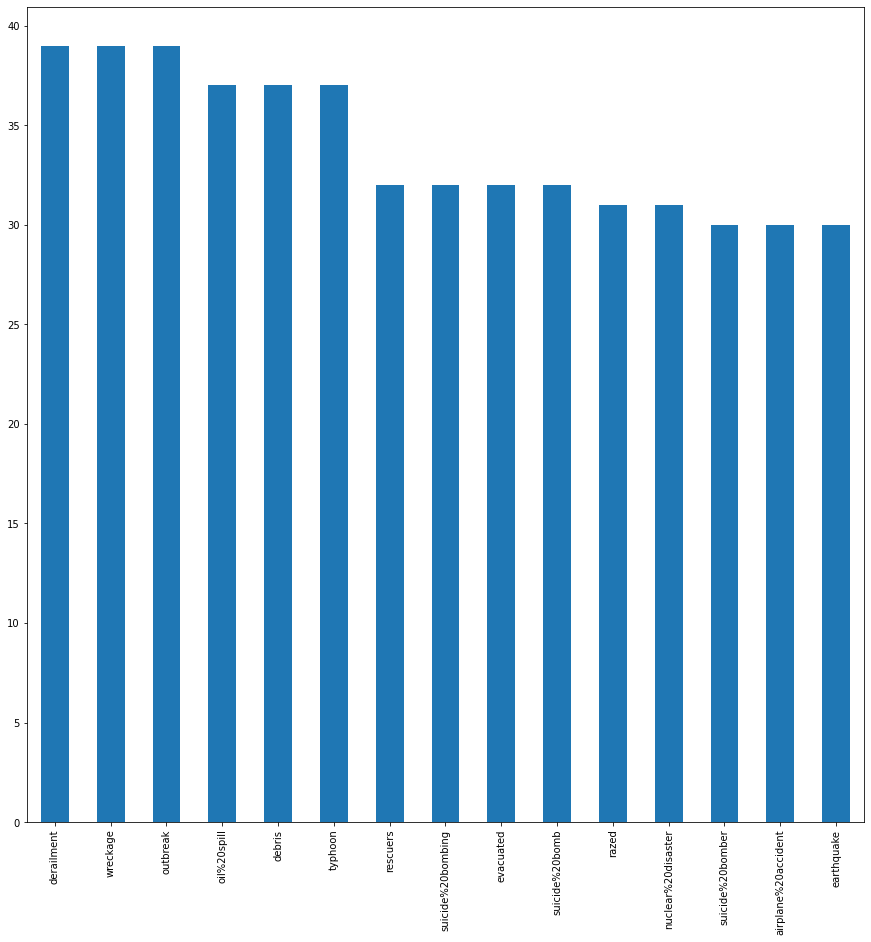

In [9]:
train[(train["target"] == 1)]["keyword"].value_counts()[0:15].plot.bar(figsize=(15, 15))


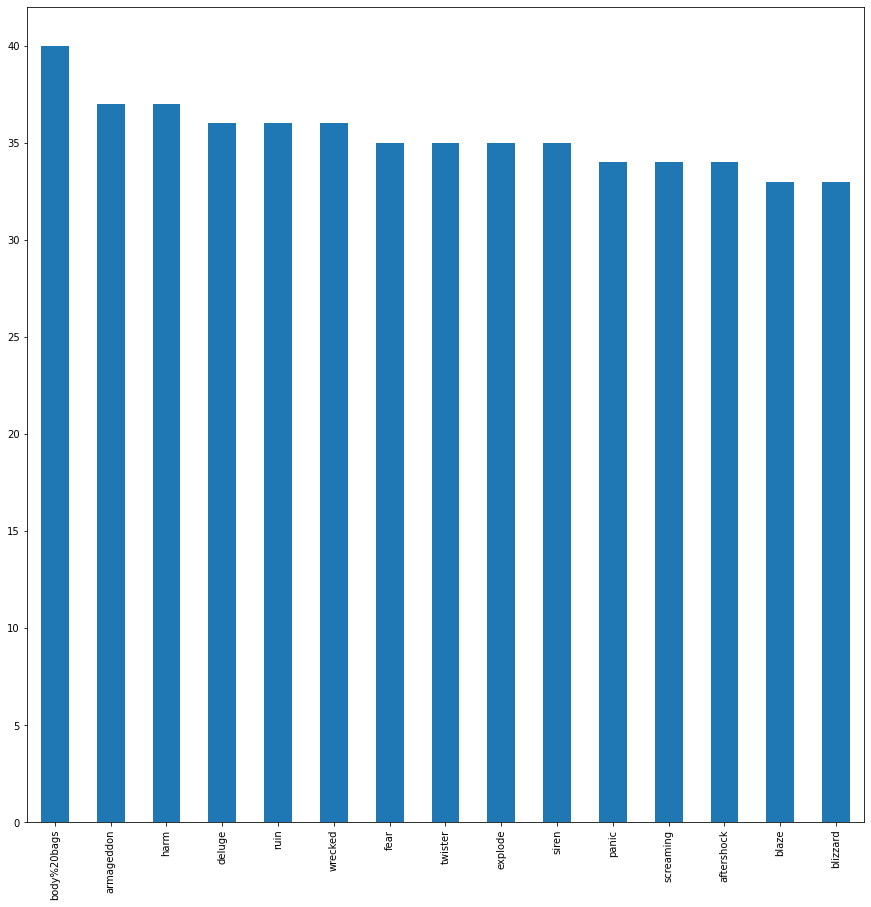

In [10]:
train[(train["target"] == 0)].keyword.value_counts()[0:15].plot.bar(figsize=(15, 15))

In [11]:
def clean_text(tweet_df):
    new_tweet_list = []
    for each_tweet in tqdm(tweet_df):
        each_tweet = each_tweet.lower()
        each_tweet = re.sub(r"https?:[^\s]+(?= |$)", "", each_tweet)
        each_tweet = re.sub(r"@[^\s]+", "", each_tweet)
        each_tweet = re.sub(r"&amp;|\||Û|û", "", each_tweet)
        each_tweet = re.sub(r"[^a-z ]", "", each_tweet)
        twitter_slangs = r"|".join(["rt","tweet", "people"])
        each_tweet = re.sub(twitter_slangs, "", each_tweet)
        #each_tweet = check(each_tweet)
        
        #each_tweet = " ".join([each_word.lemma_ for each_word in spacy_obj(each_tweet) if each_word not in stop_words])
        each_tweet = " ".join([normalize_json.get(each_word, each_word) for each_word in each_tweet.split()])
        each_tweet = " ".join([stemmer.stem(each_word) for each_word in word_tokenize(each_tweet) if each_word not in stop_words])

        
        new_tweet_list.append(each_tweet)
    new_tweet_df = pd.DataFrame(new_tweet_list)
    return new_tweet_df
train["clean_text"] = clean_text(train["text"])
test["clean_text"] = clean_text(test["text"])

100%|██████████| 3263/3263 [00:00<00:00, 4528.29it/s]


In [12]:
train["clean_text"][train["clean_text"].duplicated()]

48                                             check nsfw
106     ir icemoon aftershock dubstep trapmus dnb edm ...
114     ir icemoon aftershock dubstep trapmus dnb edm ...
115     ir icemoon aftershock dubstep trapmus dnb edm ...
116     ir icemoon aftershock dubstep trapmus dnb edm ...
                              ...                        
7608       two giant crane hold bridg collaps nearbi home
7609    control wild fire california even nohern pa st...
7610                                 utckm volcano hawaii
7611    polic investig ebik collid car littl pougal eb...
7612    latest home raze nohern california wildfir abc...
Name: clean_text, Length: 830, dtype: object

In [13]:
train["clean_text"][train[["clean_text", "target"]].duplicated()]

48                                             check nsfw
106     ir icemoon aftershock dubstep trapmus dnb edm ...
114     ir icemoon aftershock dubstep trapmus dnb edm ...
115     ir icemoon aftershock dubstep trapmus dnb edm ...
116     ir icemoon aftershock dubstep trapmus dnb edm ...
                              ...                        
7608       two giant crane hold bridg collaps nearbi home
7609    control wild fire california even nohern pa st...
7610                                 utckm volcano hawaii
7611    polic investig ebik collid car littl pougal eb...
7612    latest home raze nohern california wildfir abc...
Name: clean_text, Length: 739, dtype: object

In [14]:
duplicate_index = set(train["clean_text"][train["clean_text"].duplicated()].index) 
duplicate_index_same_target = set(train["clean_text"][train[["clean_text", "target"]].duplicated()].index)
duplicate_index_diff_target = list(duplicate_index - duplicate_index_same_target)
train["clean_text"][duplicate_index_diff_target]

5641                wowo nigerian refuge repatri cameroon
4618    clearedincid injuryi inner loop exit md georgi...
4149     love pick play woh fifth harmkid ink listen vote
569     star war power jedi collect battl droid hasbro...
570     black eye space battl occur star involv fleet ...
                              ...                        
6616    islam save person equal reward save human isla...
6108                feel like sink low selfimag take quiz
6634    here media pakistan cover captur terrorist moh...
3060                                        eahquak drill
2040    fettilootch slanglucci oppress greatest danger...
Name: clean_text, Length: 91, dtype: object

In [15]:
train = train.drop(train["clean_text"][duplicate_index_diff_target].index)

In [16]:
train["clean_text"][train["clean_text"].duplicated()].count()

739

In [17]:
train = train.drop_duplicates(subset=["clean_text"], keep="first")

In [18]:
train.count()

id            6783
keyword       6732
location      4564
text          6783
target        6783
clean_text    6783
dtype: int64

In [19]:
def plot_word_cloud(data):
    wordcloud = WordCloud(width = 2000, height = 2000,
                      background_color='white',
                min_font_size = 10).generate(data) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

## Corpus Word Cloud

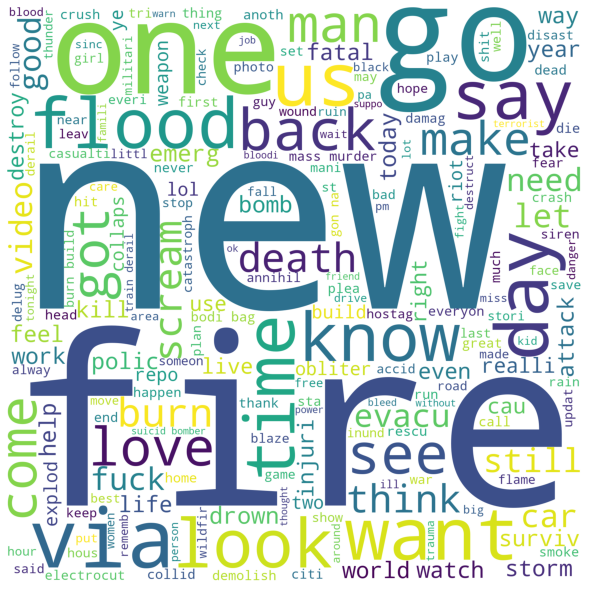

In [20]:
full_data = " ".join(train["clean_text"])
plot_word_cloud(full_data)

## Disaster Tweets Word Cloud

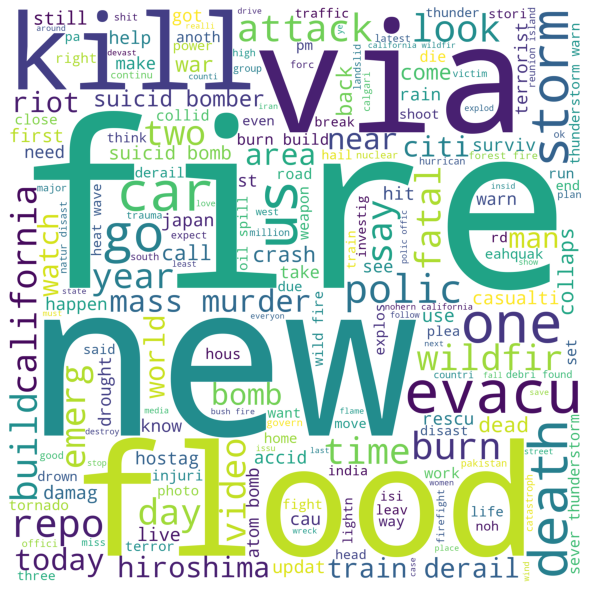

In [21]:
disaster_data = " ".join(train["clean_text"][(train["target"] == 1)])
plot_word_cloud(disaster_data)

## Non Disaster Tweets Word Cloud

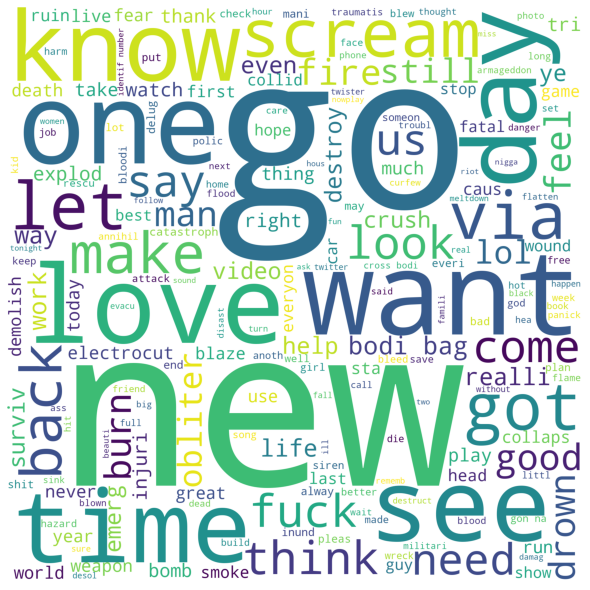

In [22]:
non_disaster_data = " ".join(train["clean_text"][(train["target"] == 0)])
plot_word_cloud(non_disaster_data)

In [23]:
from sklearn.model_selection import train_test_split
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(train, train["target"], test_size=0.3, 
                                                              stratify=train["target"])

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
max_size = max(x_train_df["clean_text"].apply(lambda sent: len(word_tokenize(sent))))
max_size

23

In [26]:
len(set(word_tokenize(" ".join(x_train_df["clean_text"]))))

9438

In [27]:
courpus_len = 8000
embed_size = 100
oov_token = "<OOV>"

### Tokenization

In [28]:
tokenizer = Tokenizer(num_words=courpus_len, oov_token=oov_token)
tokenizer.fit_on_texts(x_train_df["clean_text"])
train_sequence = tokenizer.texts_to_sequences(x_train_df["clean_text"])
val_sequence = tokenizer.texts_to_sequences(x_val_df["clean_text"])
test_sequence = tokenizer.texts_to_sequences(test["clean_text"])

In [29]:
def convert_seq_to_tfidf_seq(seq, tokenizer):
    tfidf_seq = []
    positions = tokenizer.texts_to_sequences(seq)
    matrix  = tokenizer.texts_to_matrix(seq, mode='tfidf')
    for each_pos, each_matrix in zip(positions, matrix):
        output_result = each_matrix[each_pos]
        tfidf_seq.append(output_result)
    return tfidf_seq


In [30]:
#tokenizer = Tokenizer(num_words=courpus_len, oov_token=oov_token)
#tokenizer.fit_on_texts(x_train_df["clean_text"])

#train_sequence = convert_seq_to_tfidf_seq(x_train_df["clean_text"], tokenizer)
#val_sequence = convert_seq_to_tfidf_seq(x_val_df["clean_text"], tokenizer)
#test_sequence = convert_seq_to_tfidf_seq(test["clean_text"], tokenizer)

### Padding

In [29]:
train_padded_sequence = pad_sequences(train_sequence, maxlen=max_size, padding='pre', truncating='pre')
val_padded_sequence = pad_sequences(val_sequence, maxlen=max_size, padding='pre', truncating='pre')
test_padded_sequence= pad_sequences(test_sequence, maxlen=max_size, padding='pre', truncating='pre')

In [30]:
import numpy as np
y_train_np = np.array(y_train_df)
y_val_np = np.array(y_val_df)

In [31]:
from tensorflow.keras.layers import Input, Embedding, Dropout, LSTM, Dense, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf


In [42]:
input_layer = Input(shape=(max_size,))
reshaped_layer = Embedding(courpus_len, embed_size)(input_layer)
lstm_layer = Bidirectional(LSTM(units=10, dropout=0.4, 
                                recurrent_dropout=0.4,
                                activation="relu", 
                                return_sequences=True,
                                return_state=True, unroll=True,
                                recurrent_regularizer=l1_l2(l1=0.2, l2=0.2),
                                bias_regularizer=l1_l2(l1=0.3, l2=0.3)
                               ))(reshaped_layer)
lstm_layer = Bidirectional(LSTM(units=10, dropout=0.4, 
                                recurrent_dropout=0.4,
                                activation="relu",unroll=True,
                                recurrent_regularizer=l1_l2(l1=0.2, l2=0.2),
                                bias_regularizer=l1_l2(l1=0.3, l2=0.3)
                               ))(lstm_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)
model = Model(input_layer, output_layer)

In [43]:
model.compile(loss="binary_crossentropy",
             optimizer=Adam(lr=0.001),
             metrics=["accuracy"])

In [44]:
result = model.fit(train_padded_sequence, y_train_df, 
                   validation_data=(val_padded_sequence, y_val_df), 
                   epochs=6, 
                   shuffle=True, 
                   batch_size=16)

Train on 4748 samples, validate on 2035 samples
Epoch 1/6
4748/4748 [==============================] - 41s 9ms/sample - loss: 36.0737 - accuracy: 0.5929 - val_loss: 16.9502 - val_accuracy: 0.6378
Epoch 2/6
4748/4748 [==============================] - 15s 3ms/sample - loss: 12.1022 - accuracy: 0.7584 - val_loss: 8.6788 - val_accuracy: 0.7631
Epoch 3/6
4748/4748 [==============================] - 15s 3ms/sample - loss: 6.0703 - accuracy: 0.8623 - val_loss: 4.1988 - val_accuracy: 0.7710
Epoch 4/6
4748/4748 [==============================] - 15s 3ms/sample - loss: 2.2360 - accuracy: 0.9063 - val_loss: 1.5218 - val_accuracy: 0.7602
Epoch 5/6
4748/4748 [==============================] - 15s 3ms/sample - loss: 0.2864 - accuracy: 0.9366 - val_loss: 1.1707 - val_accuracy: 0.7420
Epoch 6/6
4748/4748 [==============================] - 15s 3ms/sample - loss: 0.1588 - accuracy: 0.9556 - val_loss: 1.4023 - val_accuracy: 0.7307


In [45]:
result.history

{'loss': [36.07372247299027,
  12.102169575164975,
  6.070267614639398,
  2.2360096410632435,
  0.2864256695088661,
  0.15884225605261257],
 'accuracy': [0.5928812,
  0.7584246,
  0.8622578,
  0.90627635,
  0.93660486,
  0.9555602],
 'val_loss': [16.950165675957606,
  8.678827319977032,
  4.1988367223622465,
  1.5218037902869521,
  1.1706618442582264,
  1.4022967623258398],
 'val_accuracy': [0.6378378,
  0.76314497,
  0.77100736,
  0.76019657,
  0.74201477,
  0.73071253]}

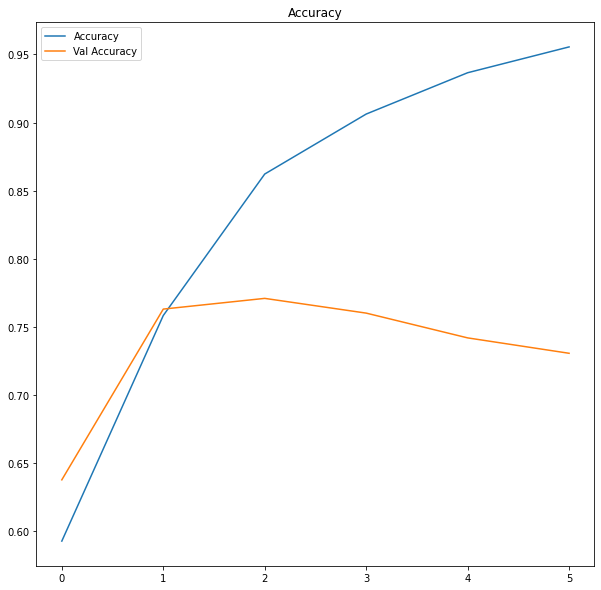

In [46]:
plt.figure(figsize=(10, 10))
plt.title("Accuracy")
plt.plot(result.history["accuracy"], label="Accuracy")
plt.plot(result.history["val_accuracy"], label="Val Accuracy")
plt.legend()

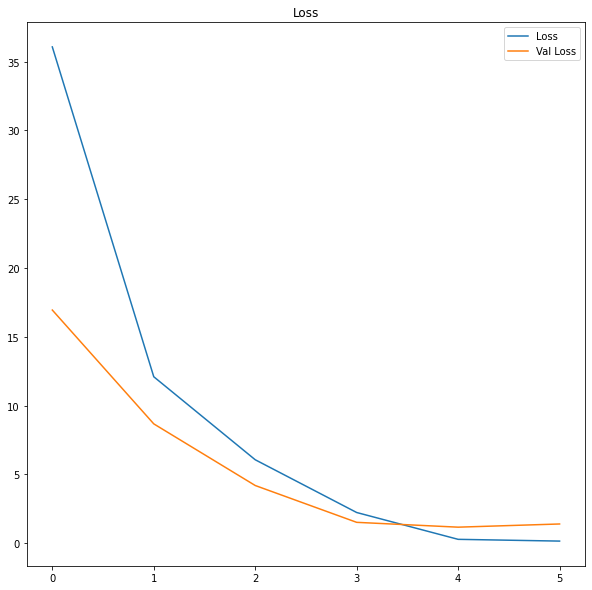

In [47]:
plt.figure(figsize=(10, 10))
plt.title("Loss")
plt.plot(result.history["loss"], label="Loss")
plt.plot(result.history["val_loss"], label="Val Loss")
plt.legend()

In [48]:
model.evaluate(val_padded_sequence, y_val_df)

2035/2035 [==============================] - 1s 409us/sample - loss: 1.4023 - accuracy: 0.7307


[1.4022967646104405, 0.73071253]

In [49]:
val_output_result = list(map( lambda each_score: 1 if each_score > 0.5 else 0, model.predict(val_padded_sequence).flatten()))

In [50]:
model.predict(val_padded_sequence).flatten()

array([9.8590350e-01, 9.9782950e-01, 7.2249913e-01, ..., 6.9928330e-01,
       1.0790283e-06, 2.2592023e-03], dtype=float32)

In [51]:
from sklearn.metrics import classification_report

In [52]:
print(classification_report(y_val_df, val_output_result))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1199
           1       0.67      0.68      0.67       836

    accuracy                           0.73      2035
   macro avg       0.72      0.72      0.72      2035
weighted avg       0.73      0.73      0.73      2035



Area Under the Curve :  0.7229489486853079


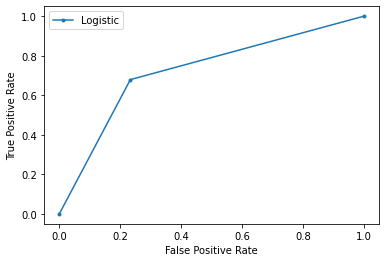

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_val_df, val_output_result)
lr_fpr, lr_tpr, threshold  = roc_curve(y_val_df, val_output_result)
print("Area Under the Curve : ", lr_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [54]:
output_result = pd.DataFrame()
lstm_prediction = model.predict(test_padded_sequence)
lstm_prediction = [1 if each_result > 0.7 else 0 for each_result in lstm_prediction.flatten()]
output_result["target"] = lstm_prediction
output = pd.concat([test["id"].reset_index(drop=True),output_result.reset_index(drop=True)], axis=1)
output.to_csv("submission.csv", index=False)